In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e9/sample_submission.csv
/kaggle/input/playground-series-s5e9/train.csv
/kaggle/input/playground-series-s5e9/test.csv


# Сиды(ну типо)

In [2]:
seed=42

In [3]:
import random
import torch
import numpy as np

In [4]:
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# Импорты

In [5]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso
import optuna
from sklearn.tree import DecisionTreeRegressor


# Загрузка данных

In [6]:
train=pd.read_csv('/kaggle/input/playground-series-s5e9/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e9/test.csv')
sample=pd.read_csv('/kaggle/input/playground-series-s5e9/sample_submission.csv')


In [7]:
drop_cols=['id']

In [8]:
train=train.drop(columns=drop_cols)
test=test.drop(columns=drop_cols)

In [9]:
num_feats=train.select_dtypes(include='number').columns.tolist()
cat_feats=train.select_dtypes(include='object').columns.tolist() # их нету


# EDA

In [10]:
train.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                524164 non-null  float64
 1   AudioLoudness              524164 non-null  float64
 2   VocalContent               524164 non-null  float64
 3   AcousticQuality            524164 non-null  float64
 4   InstrumentalScore          524164 non-null  float64
 5   LivePerformanceLikelihood  524164 non-null  float64
 6   MoodScore                  524164 non-null  float64
 7   TrackDurationMs            524164 non-null  float64
 8   Energy                     524164 non-null  float64
 9   BeatsPerMinute             524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB


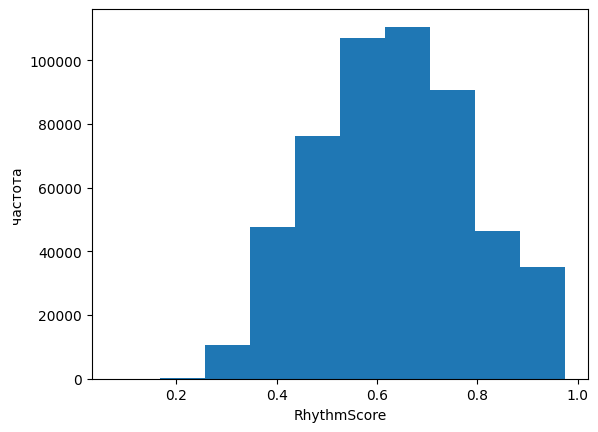

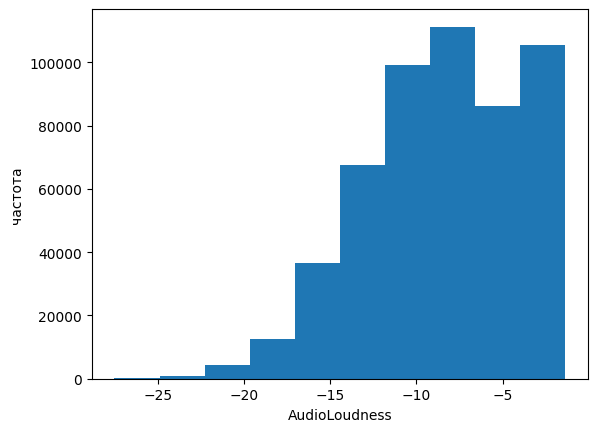

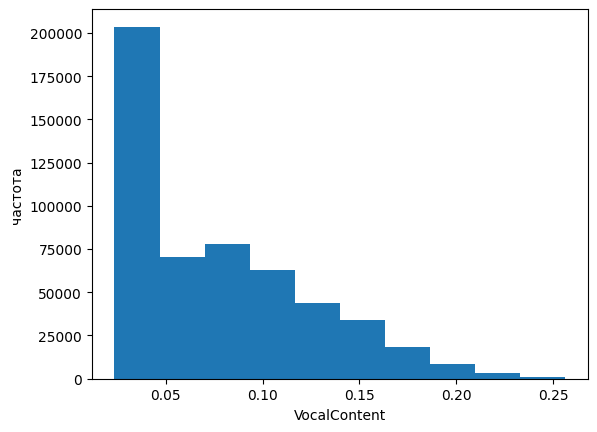

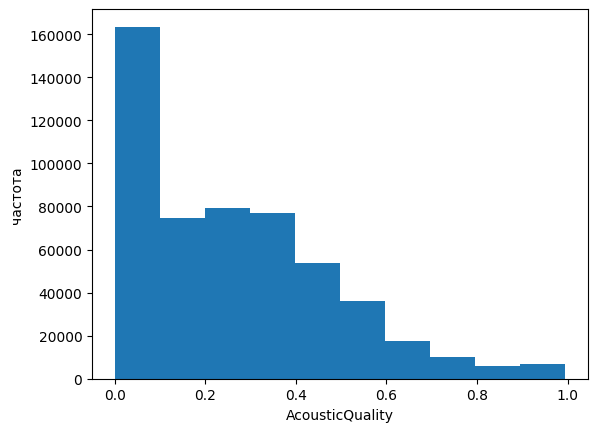

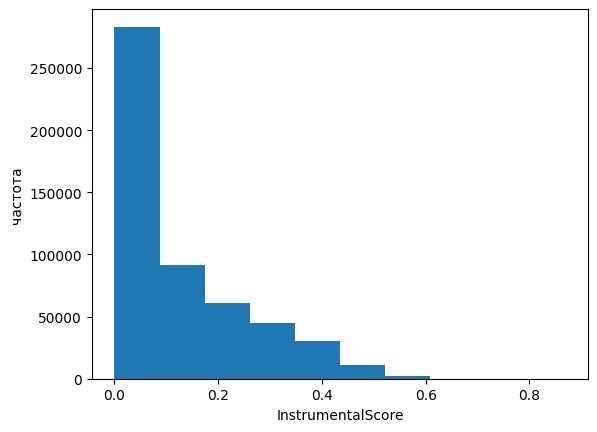

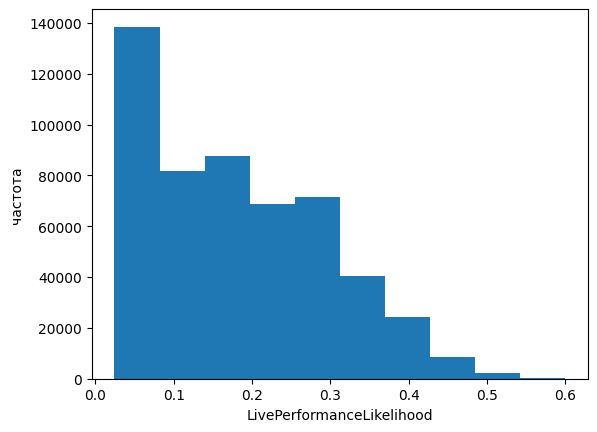

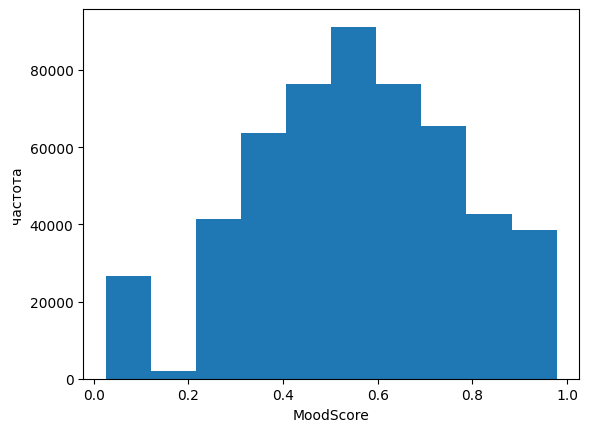

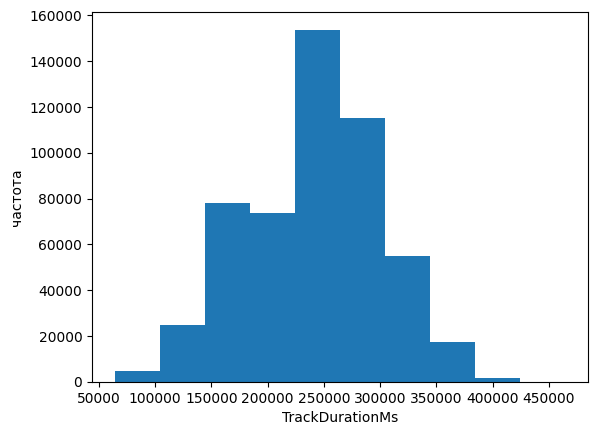

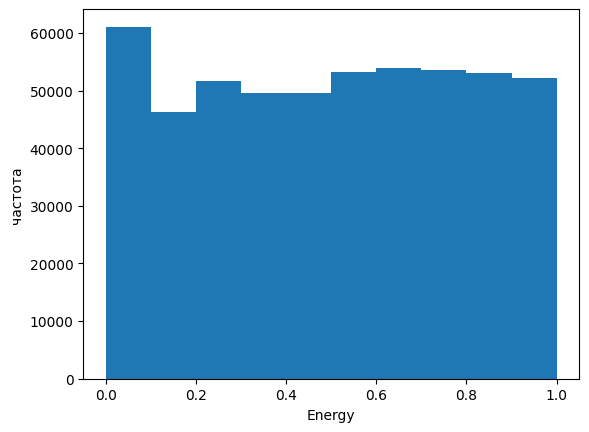

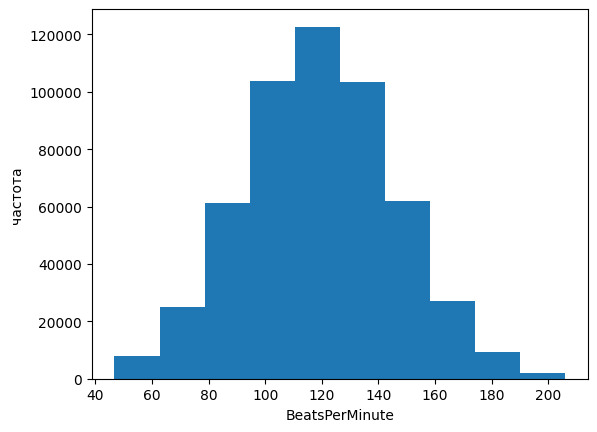

In [12]:
for col in num_feats:
    plt.figure()
    plt.hist(train[col])
    plt.xlabel(col)
    plt.ylabel('частота')
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


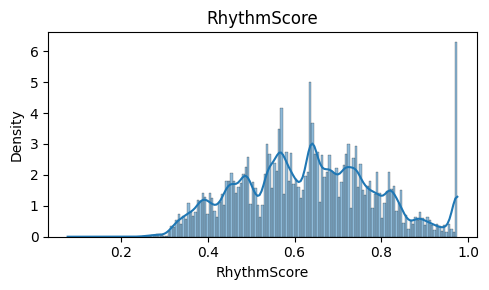

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


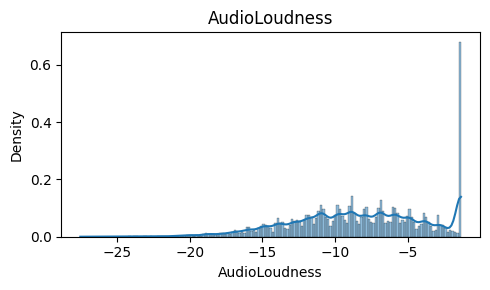

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


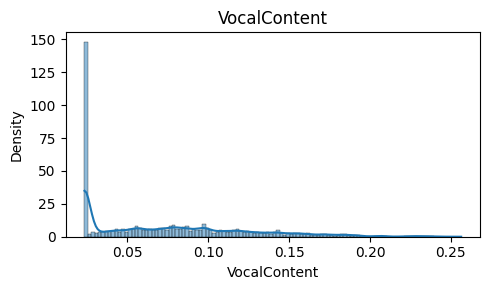

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


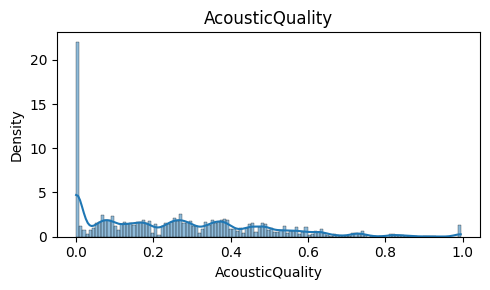

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


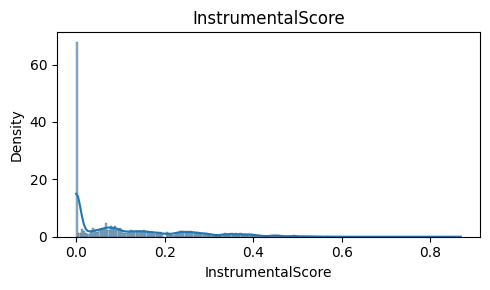

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


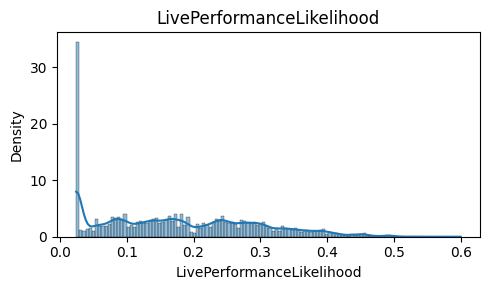

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


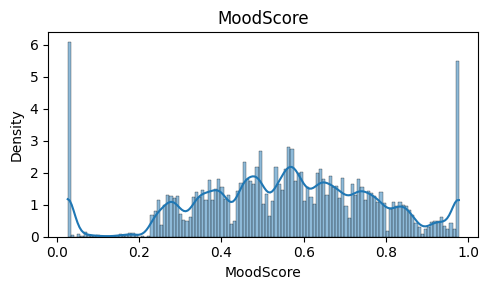

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


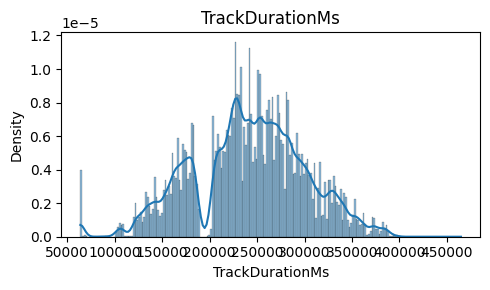

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


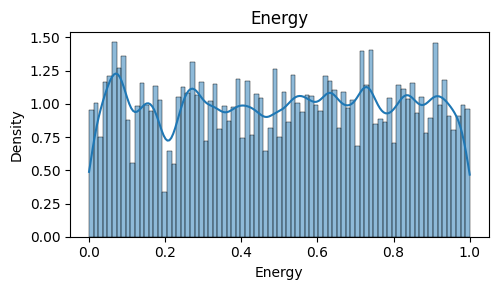

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


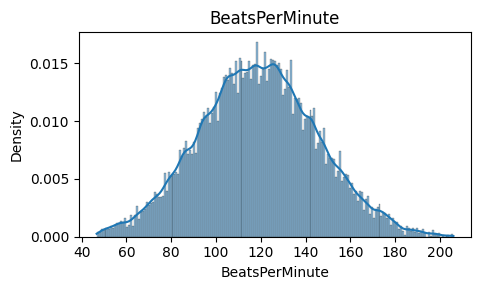

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in num_feats:
    plt.figure(figsize=(5,3))
    sns.histplot(train[col].dropna(), bins='auto', kde=True, stat='density')
    plt.title(col)
    plt.tight_layout()
    plt.show()


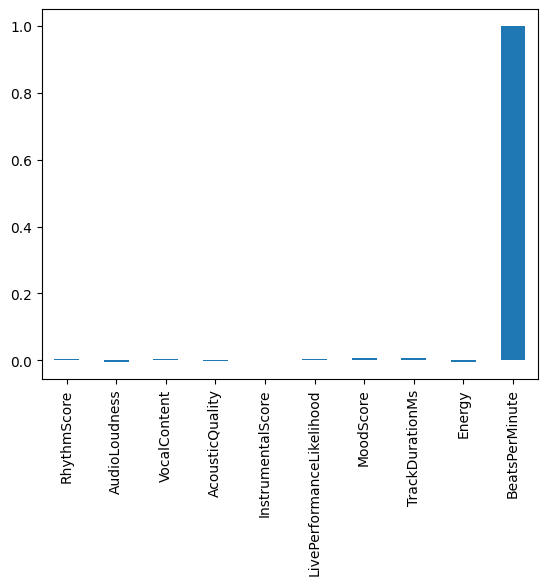

In [14]:
goal=train.corrwith(train['BeatsPerMinute']) # мщжно методы разные пробовать 
plt.figure()
goal.plot(kind='bar')
plt.show()

In [15]:
goal

RhythmScore                  0.005440
AudioLoudness               -0.003327
VocalContent                 0.004876
AcousticQuality             -0.000820
InstrumentalScore            0.001900
LivePerformanceLikelihood    0.003471
MoodScore                    0.007059
TrackDurationMs              0.006637
Energy                      -0.004375
BeatsPerMinute               1.000000
dtype: float64

In [16]:
goal

RhythmScore                  0.005440
AudioLoudness               -0.003327
VocalContent                 0.004876
AcousticQuality             -0.000820
InstrumentalScore            0.001900
LivePerformanceLikelihood    0.003471
MoodScore                    0.007059
TrackDurationMs              0.006637
Energy                      -0.004375
BeatsPerMinute               1.000000
dtype: float64

# Feature engineering

RhythmScore                  0.005440
AudioLoudness               -0.003327
VocalContent                 0.004876
AcousticQuality             -0.000820
InstrumentalScore            0.001900
LivePerformanceLikelihood    0.003471
MoodScore                    0.007059
TrackDurationMs              0.006637
Energy                      -0.004375
BeatsPerMinute               1.000000


идеи для фичей 

логарифмировать  InstrumentalScore   и   VocalContent

df['new_feat1']= (AudioLoudness * RhythmScore) / TrackDurationMs

df['new_feat2']= VocalContent ** InstrumentalScore
df['new_feat3']= Energy + MoodScore 
df['new_feat4']= TrackDurationMs* RhythmScore -(AcousticQuality + InstrumentalScore)
df['new_feat5']=MoodScore- AudioLoudness**TrackDurationMs
df['new_feat6']=(LivePerformanceLikelihood+VocalContent+AcousticQuality)/100



НУЖНО ПРАКТИКОВАТЬ АГРЕГРЕГИРОВАННЫЕ ФИЧИ 

In [17]:
def featurize(df):
    #InstrumentalScore   и   VocalContent
    df['log_InstrumentalScore']=np.log1p(df['InstrumentalScore'].astype(float))
    df['log_VocalContent']=np.log1p(df['VocalContent'].astype(float))
    df['new_feat1']= (df['AudioLoudness'] * df['RhythmScore']) / df['TrackDurationMs']

    df['new_feat2']= df['VocalContent'] ** df['InstrumentalScore']
    df['new_feat3']= df['Energy'] + df['MoodScore'] 
    df['new_feat4']= df['TrackDurationMs']* df['RhythmScore'] -(df['AcousticQuality'] + df['InstrumentalScore'])
    df['new_feat5']=df['MoodScore']- df['RhythmScore']**df['TrackDurationMs']
    df['new_feat6']=(df['LivePerformanceLikelihood']+df['VocalContent']+df['AcousticQuality'])/100

    #new
    df['new_feat7']=(df['MoodScore']+df['log_VocalContent'])/df['RhythmScore']
    df['new_feat8']=df['VocalContent']*df['log_InstrumentalScore'] + df['MoodScore']

    #new new

    df['new_feat9']=df['MoodScore']/df['Energy']+df['AudioLoudness']-df['AcousticQuality']
    df['new_feat10']=df['AudioLoudness']+df['InstrumentalScore']-df['log_InstrumentalScore']
    df['new_feat11']=df['TrackDurationMs']-df['VocalContent']-df['MoodScore']

    df['new_feat12']=df['new_feat7']/df['new_feat5']
    return df

## apply

In [18]:
train_new=featurize(train)
test_new=featurize(test)

In [19]:
train_new

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute,...,new_feat3,new_feat4,new_feat5,new_feat6,new_feat7,new_feat8,new_feat9,new_feat10,new_feat11,new_feat12
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020,...,1.236133,175478.788781,0.409866,0.000749,0.717507,0.409866,-7.140901,-7.636942,290715.211634,1.750589
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963,...,0.796410,105201.411607,0.651010,0.006870,1.126103,0.672443,-12.235153,-16.217855,164518.794870,1.729778
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989,...,1.048532,89783.944292,0.423865,0.003140,1.027851,0.465293,-15.448728,-15.873952,174495.032121,2.424950
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212,...,0.766212,165670.707104,0.278745,0.001410,0.449791,0.286593,-0.786827,-1.345459,225567.133390,1.613629
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511,...,1.425102,114034.230409,0.477769,0.004235,0.940013,0.477769,-12.620794,-13.056437,213960.177631,1.967504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524159,0.796831,-13.405645,0.023500,0.504738,0.000001,0.191414,0.668079,135528.3189,0.004400,117.83118,...,0.672479,107992.695291,0.668079,0.007197,0.867570,0.668079,137.925732,-13.405645,135527.627321,1.298604
524160,0.975000,-12.132914,0.077379,0.069462,0.262320,0.124818,0.288946,240709.3918,0.447067,89.02681,...,0.736013,234691.325224,0.288946,0.002717,0.372797,0.306972,-11.556061,-12.103546,240709.025475,1.290197
524161,0.542958,-1.357000,0.071390,0.168978,0.000001,0.313912,0.586868,344858.2321,0.718800,90.75885,...,1.305668,187243.364592,0.586868,0.005543,1.207873,0.586868,-0.709523,-1.357000,344857.573843,2.058168
524162,0.637192,-7.411331,0.113086,0.000005,0.061946,0.287963,0.368891,322710.3187,0.944267,140.63235,...,1.313158,205628.344012,0.368891,0.004011,0.747070,0.375688,-7.020672,-7.409488,322709.836723,2.025178


In [20]:
trying=train_new.corrwith(train_new['BeatsPerMinute'])

In [21]:
trying

RhythmScore                  0.005440
AudioLoudness               -0.003327
VocalContent                 0.004876
AcousticQuality             -0.000820
InstrumentalScore            0.001900
LivePerformanceLikelihood    0.003471
MoodScore                    0.007059
TrackDurationMs              0.006637
Energy                      -0.004375
BeatsPerMinute               1.000000
log_InstrumentalScore        0.001988
log_VocalContent             0.004816
new_feat1                   -0.000413
new_feat2                   -0.001220
new_feat3                    0.001005
new_feat4                    0.008774
new_feat5                    0.007059
new_feat6                    0.001839
new_feat7                    0.001761
new_feat8                    0.007266
new_feat9                   -0.001887
new_feat10                  -0.003321
new_feat11                   0.006637
new_feat12                  -0.004186
dtype: float64

# skf catboost(or something else maybe?)

In [22]:
X=train_new.drop(columns='BeatsPerMinute')
y=train_new['BeatsPerMinute']

In [23]:
y = np.log1p(y)            # ln(1 + y)
def inv_log(pred):
    return np.expm1(pred) 

In [24]:
#C = float(max(y.max(), 1.0))    # большая константа; можно зафиксировать, напр. C=1000.0
#y_scaled = y / C
#def inv_scale(pred):
 #   return pred * C

In [25]:
model_cfgs = [
    dict(name="depth6_lr0.03",
         params=dict(iterations=2000, learning_rate=0.03, depth=6, loss_function='RMSE',
                     l2_leaf_reg=3.0, task_type='GPU', devices='0', random_seed=42)),
    dict(name="cb_depth8_lr0.02",
         params=dict(iterations=3000, learning_rate=0.02, depth=8, loss_function='RMSE',
                     l2_leaf_reg=6.0,  task_type='GPU', devices='0', random_seed=42)),
    dict(name="depth10_lr0.015",
         params=dict(iterations=4000, learning_rate=0.015, depth=10, loss_function='RMSE',
                     l2_leaf_reg=8.0, bagging_temperature=0.5, task_type='GPU', devices='0', random_seed=42)),
    dict(name="growlossols_lr0.03",
         params=dict(iterations=2500, learning_rate=0.03, depth=7, loss_function='RMSE',
                     grow_policy='Lossguide', l2_leaf_reg=4.0, task_type='GPU', devices='0', random_seed=42)),
    dict(name="border64_lr0.025",
         params=dict(iterations=2500, learning_rate=0.025, depth=6, loss_function='RMSE',
                     border_count=64, l2_leaf_reg=5.0, task_type='GPU', devices='0', random_seed=42)),
]

In [26]:
kf=KFold(n_splits=5, shuffle=True,  random_state=42)
n_models = len(model_cfgs)
oof_preds  = np.zeros((len(y), n_models), dtype=float)
test_preds = np.zeros((len(test_new),  n_models), dtype=float)

cv_scores  = []

for m_idx, cfg in enumerate(model_cfgs):
    name, params=cfg['name'], cfg['params']
    oof_pred=np.zeros(len(y), dtype=float)
    test_pred=np.zeros(len(test_new), dtype=float)
    fold_rmse = []
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X,y), start=1):
        X_train, X_val=X.iloc[tr_idx], X.iloc[val_idx]
        y_train, y_val=y.iloc[tr_idx], y.iloc[val_idx]
        train_pool=Pool(
        data=X_train,
        label=y_train
        )
        val_pool=Pool(
        data=X_val,
        label=y_val
        )
        test_pool=Pool(
        data=test_new
        )
        model=CatBoostRegressor(
        **params
        
        )
        model.fit(train_pool, eval_set=val_pool, verbose=200, use_best_model=True, early_stopping_rounds=400)
        val_pred = model.predict(val_pool)
        oof_pred[val_idx] = val_pred
        fold_rmse.append(mean_squared_error(y_val, val_pred, squared=False))

        test_pred += model.predict(test_pool) / 5
    print(f'CV RMSE: {np.mean(fold_rmse):.5f} ± {np.std(fold_rmse):.5f}')
    oof_preds[:, m_idx]  = oof_pred
    test_preds[:, m_idx] = test_pred
    model_cv = (np.mean(fold_rmse), np.std(fold_rmse))
    cv_scores.append((name, *model_cv))
    print(f"{name}: CV RMSE {model_cv[0]:.5f} ± {model_cv[1]:.5f}")



0:	learn: 0.2329813	test: 0.2330762	best: 0.2330762 (0)	total: 9.73s	remaining: 5h 24m 12s
200:	learn: 0.2326516	test: 0.2330134	best: 0.2330096 (92)	total: 10.6s	remaining: 1m 34s
400:	learn: 0.2324213	test: 0.2330194	best: 0.2330096 (92)	total: 11.4s	remaining: 45.6s
bestTest = 0.2330095965
bestIteration = 92
Shrink model to first 93 iterations.
0:	learn: 0.2329683	test: 0.2331207	best: 0.2331207 (0)	total: 5.01ms	remaining: 10s
200:	learn: 0.2326411	test: 0.2330379	best: 0.2330364 (150)	total: 852ms	remaining: 7.62s
400:	learn: 0.2324130	test: 0.2330426	best: 0.2330364 (150)	total: 1.71s	remaining: 6.82s
bestTest = 0.2330363707
bestIteration = 150
Shrink model to first 151 iterations.
0:	learn: 0.2328694	test: 0.2335212	best: 0.2335212 (0)	total: 5.63ms	remaining: 11.3s
200:	learn: 0.2325394	test: 0.2334332	best: 0.2334314 (194)	total: 864ms	remaining: 7.73s
400:	learn: 0.2323135	test: 0.2334390	best: 0.2334314 (194)	total: 1.71s	remaining: 6.81s
bestTest = 0.2334313894
bestIteratio

In [27]:
colnames = [cfg["name"] for cfg in model_cfgs]
oof_df   = pd.DataFrame(oof_preds,  columns=colnames)
test_df  = pd.DataFrame(test_preds, columns=colnames)

## Trying to do meta model

## Линейная регрессия как мета модель

In [28]:
model_lasso=Lasso(alpha=1)


In [29]:
model_lasso.fit(oof_df, y)

linreg_test_pred = model_lasso.predict(test_df)


In [30]:
sub1=pd.DataFrame({
    'id': sample['id'],
    'BeatsPerMinute' : linreg_test_pred
})

In [31]:
sub1.to_csv('sub_linear_reg2.csv', index=False)

## Катбуст как мета модель

In [32]:
model_cat=CatBoostRegressor(
    iterations=500,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=10.0,
    task_type='GPU',
    devices='0',
    loss_function='RMSE',
    
)

In [33]:
model_cat.fit(oof_df, y, verbose=False)

catboost_test_pred=np.expm1(model_cat.predict(test_df))


In [34]:
sub2=pd.DataFrame({
    'id': sample['id'],
    'BeatsPerMinute': catboost_test_pred
})

In [35]:
sub2.to_csv('sub_catboost.csv', index=False)

## Дерево как мета модель

In [36]:
model_tree=DecisionTreeRegressor(
    max_depth=3, 
    min_samples_leaf=100,
    random_state=42
)

In [37]:
model_tree.fit(oof_df, y )
tree_test_pred=model_tree.predict(test_df)


In [38]:
sub3=pd.DataFrame({
    'id': sample['id'],
    'BeatsPerMinute': tree_test_pred
})

In [39]:
sub3.to_csv('sub_decision_tree.csv', index=False)

## 

##  

# Submission

## Байесовская опт

In [40]:
def objective(trial):
     raw = np.array([trial.suggest_float(f"w{i}", 0.0, 1.0) for i in range(n_models)])
     w = raw / (raw.sum() + 1e-12)
     blend = oof_df.values @ w
     return mean_squared_error(y, blend, squared=False)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)
best_raw = np.array([study.best_params[f"w{i}"] for i in range(n_models)])
w = best_raw / (best_raw.sum() + 1e-12)
print("Best weights:", dict(zip(colnames, w.round(4))))
test_blend = np.expm1(test_df.values @ w)

#Своровал но понял что происходит, надо самим реализовать в след ноутбуке

[I 2025-09-05 20:08:40,965] A new study created in memory with name: no-name-546dcda7-ac1f-4748-bc71-a2bbe873794c
[I 2025-09-05 20:08:40,974] Trial 0 finished with value: 0.23291671227650299 and parameters: {'w0': 0.28806886332817416, 'w1': 0.0955635101253276, 'w2': 0.9780761548149903, 'w3': 0.38146167435445955, 'w4': 0.8865035827575404}. Best is trial 0 with value: 0.23291671227650299.
[I 2025-09-05 20:08:40,979] Trial 1 finished with value: 0.2329174975270429 and parameters: {'w0': 0.092575615879676, 'w1': 0.8139423753165989, 'w2': 0.646505536659735, 'w3': 0.3874725821830197, 'w4': 0.2329819652052043}. Best is trial 0 with value: 0.23291671227650299.
[I 2025-09-05 20:08:40,984] Trial 2 finished with value: 0.23291658506224241 and parameters: {'w0': 0.8739216145487364, 'w1': 0.1214299291639247, 'w2': 0.4228141935516879, 'w3': 0.9640550772963618, 'w4': 0.20339695935291324}. Best is trial 2 with value: 0.23291658506224241.
[I 2025-09-05 20:08:40,989] Trial 3 finished with value: 0.23291

Best weights: {'depth6_lr0.03': 0.0004, 'cb_depth8_lr0.02': 0.0001, 'depth10_lr0.015': 0.1261, 'growlossols_lr0.03': 0.4836, 'border64_lr0.025': 0.3898}


In [41]:
sub4=pd.DataFrame({
    'id': sample['id'],
    'BeatsPerMinute': test_blend
})

In [42]:
sub4.to_csv('sub_optuna.csv', index=False)

In [43]:
sub_total=pd.DataFrame({
    'id': sample['id'],
    'BeatsPerMinute': 0.4* sub4['BeatsPerMinute'] + 0.6 * sub2['BeatsPerMinute']
})

In [44]:
sub_total.to_csv('sub_catboost_plus_optuna_opt.csv', index=False)

## Hill climbing